# Common code necessary to run

## Define inputs

### Define feature information

In [2]:
%run common.ipynb

['LC_Type1', 'LST_Day_1km', 'pr', 'aet', 'NDVI', 'EVI']
['LST_Day_1km', 'pr', 'aet', 'NDVI', 'EVI']
['LC_Type1']


### Define global variables

In [3]:
upstream_train_start_year = 2015
upstream_train_end_year = 2021
downstream_train_start_year = 2000
downstream_train_end_year = 2022

In [4]:
BUCKET_NAME = 'lue-model'
BUCKET_FOLDER = 'annual'
UPSTREAM_SUB_FOLDER = 'MODIS_Gpp_Unnormalized'
DOWNSTREAM_SUB_FOLDER = 'fluxnet'
COMPARE_UPSTREAM_SUB_FOLDER = 'MODIS_in_fluxnet'

# Sample & Export

In [ ]:
import ee
import os
project = "carbonsequestration"
os.environ["GOOGLE_CLOUD_PROJECT"] = project
ee.Authenticate()
ee.Initialize(
    project=project,
    opt_url="https://earthengine-highvolume.googleapis.com")

In [6]:
SAMPLE_SCALE = 500
SAMPLE_POINT_DEFAULT = 400
# SAMPLE_POINT_DEFAULT = 800

In [7]:
countries = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017")
country_names = ['Canada', 'United States', 'Belgium', 'Czechia', 'Denmark', 'Finland', 'France', 'Germany', 'Greenland', 'Italy', 'Netherlands', 'Norway', 'Spain', 'Sweden', 'Switzerland']
country_sample_point = {'Canada': 1000, 'United States': 2000}
# country_sample_point = {'Canada': 3000, 'United States': 5000}

## Define global functions

In [9]:
def get_range_start_from_month(year, month, gap=1):
    start = ee.Date(f'{year}-{month:02d}-01')
    end = start.advance(gap, 'month')
    return (start, end)

def get_range_from_year(year):
  return (f'{year}-01-01', f'{year}-12-31')

In [10]:
# aggregate monthly precipitation into annual
def sum_maps(map_info, start_date, end_date):
    collection = ee.ImageCollection(map_info['name']).filterDate(start_date, end_date).select(map_info['band'])
    if collection.size().getInfo()>0:
        img = collection.reduce(ee.Reducer.sum()).select(map_info['band']+'_sum')
        img = img.rename(map_info['band'])
        return img
    else:
        print(f"no {map_info['band']} in {start_date}-{end_date}")
        return None        

def median_maps(map_info, start_date, end_date):
    collection = ee.ImageCollection(map_info['name']).filterDate(start_date, end_date)
    if collection.size().getInfo()>0:
        return collection.select(map_info['band']).median()
    else:
        print(f"no {map_info['band']} in {start_date}-{end_date}")
        return None

In [23]:
def process_img_value(img, map_info):
    # unmask_value = map_info['min'] - (map_info['max'] - map_info['min'])*0.1
    # return img.clamp(map_info['min'], map_info['max']).float().unmask(unmask_value)    
    # return img.unitScale(map_info['min'], map_info['max']).float()   
    return img.float()

In [12]:
def get_img_from_collection(map_info, start_date, end_date):
    if map_info.get('sum'):
        img = sum_maps(map_info, start_date, end_date)
    else:
        img = median_maps(map_info, start_date, end_date)
    
    if img:
        return process_img_value(img, map_info)
    return None

In [13]:
def get_input_image(start_date, end_date) -> ee.Image:
    combined_image = get_img_from_collection(feature_list[0], start_date, end_date)
    if combined_image:
        for i in range(1, len(feature_list)):
            img = get_img_from_collection(feature_list[i], start_date, end_date)
            if img:
                combined_image = ee.Image.cat([combined_image, img])
            else:
                combined_image = None
                break
    return combined_image

In [14]:
def get_label_image(start_date, end_date) -> ee.Image:
  return get_img_from_collection(gpp_map_info, start_date, end_date)

In [16]:
# !jupyter trust Natural_Factors_Impacting_Carbon_Sequestration.ipynb

In [17]:
# import folium

# (visualize_start_date, visualize_end_date) = get_range_from_year(train_start_year)
# def get_tile_layer(map_info):
#   if map_info.get('sum'):
#     image = sum_maps(map_info, visualize_start_date, visualize_end_date)
#   else:
#     image = median_maps(map_info, visualize_start_date, visualize_end_date)
#   image=image.clip(Canada)
#   vis_params = {
#     'bands': [map_info['band']],
#     'min': map_info['min'],
#     'max': map_info['max'],
#     }
#   if isinstance(map_info['vis'], dict):
#     vis_params['palette'] = list(map_info['vis'].values())
#   else:
#     vis_params['palette'] = map_info['vis']
#   mapid = image.getMapId(vis_params)
#   return folium.TileLayer(
#     tiles=mapid['tile_fetcher'].url_format,
#     attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
#     overlay=True,
#     name=map_info['band'],
#   )

# map = folium.Map(location=(center[1], center[0]), zoom_start=7)
# for map_info in feature_list:
#   get_tile_layer(map_info).add_to(map)

# get_tile_layer(gpp_map_info).add_to(map)

# folium.LayerControl().add_to(map)
# map

## Export data

In [18]:
def get_combined_data(start_year, end_year, include_target=True):
    combine_image_list = []
    time_desc_list = []
    for year in range(start_year, end_year+1):
        time_range=get_range_from_year(year)
        input_image = get_input_image(time_range[0], time_range[1])
        combine_image = input_image
        if combine_image:
            if include_target:
                target_image = get_label_image(time_range[0], time_range[1])
                combine_image = ee.Image.cat([combine_image, target_image])
            # print(input_image.bandNames().getInfo())
            combine_image_list.append(combine_image)
            time_desc_list.append(year)
    return combine_image_list, time_desc_list

In [19]:
def add_coordinate_to_feature(feature):
    centroid = feature.geometry().centroid()
    return ee.Feature(centroid, {'cx': centroid.coordinates().get(0),'cy': centroid.coordinates().get(1)}).copyProperties(feature)

In [20]:
def get_proper_shards(sample_num):
    sample_per_shard = 50
    return sample_num / sample_per_shard

### Export training data

In [21]:
import time
import random

random.seed(int(time.time()))
max_shard_per_file = 10

def export_feature_collections(collection, desc, export_path_prefix: str):
    # print(desc)
    task = ee.batch.Export.table.toCloudStorage(
            collection = collection,
            description = f'{desc}',
            bucket = BUCKET_NAME,
            fileNamePrefix = f'annual/{export_path_prefix}{desc}',
            fileFormat = 'TFRecord'
        )
    task.start()

def sample_points(
    region: ee.Geometry, num_pixels: int, scale: int, folder: str, country_name:str 
):
    sample_shard = int(get_proper_shards(num_pixels))
    num_pixels = int(num_pixels/sample_shard)
    print(f'sample_shard={sample_shard}')
    combine_image_list, time_desc_list = get_combined_data(upstream_train_start_year, upstream_train_end_year)
    for i,image in enumerate(combine_image_list):
        collection = ee.FeatureCollection([])
        for j in range(sample_shard):
            is_new_shard = j%max_shard_per_file == 0
            if is_new_shard:
                collection = ee.FeatureCollection([])
            seed = int(random.random() * random.randint(0, int(time.time())))
            geometry = image.sample(
                region=region,
                scale=scale,
                numPixels=num_pixels,
                seed=int(random.random() * random.randint(0, int(time.time()))),
                geometries=True
            )
            collection = collection.merge(geometry)
            collection = collection.map(add_coordinate_to_feature)
            export_cur_collection = (j+1)%max_shard_per_file == 0 or (j+1) == sample_shard
            if export_cur_collection:
                export_feature_collections(collection, f'{country_name}_{time_desc_list[i]}_{int(j/max_shard_per_file)}', f'{folder}/')
    

In [24]:
def export_data():
    for i, country_name in enumerate(country_names):
        geometry = countries.filter(ee.Filter.eq('country_na', country_name)).geometry()
        samples = country_sample_point.get(country_name) if country_sample_point.get(country_name) else SAMPLE_POINT_DEFAULT
        sample_points(geometry, samples, SAMPLE_SCALE, UPSTREAM_SUB_FOLDER+'_extra', country_name)
        
export_data()

sample_shard=20
sample_shard=40
sample_shard=8
sample_shard=8
sample_shard=8
sample_shard=8
sample_shard=8
sample_shard=8
sample_shard=8
sample_shard=8
sample_shard=8
sample_shard=8
sample_shard=8
sample_shard=8
sample_shard=8


### Export FLUXNET features

#### Read FLUXNET data

In [5]:
FLUX_FOLDER = "../fluxnet_data/"
EU_SITE_FILE = "Euro-sites.csv"
EU_GPP_FOLDER = "euro/"
NA_SITE_FILE = "AmeriFlux-sites.tsv"
NA_GPP_FOLDER = "north-america/"

EU_SITE_HEADER  = ["Site Code", "Site Latitude", "Site Longitude"]
NA_SITE_HEADER  = ["Site ID", "Latitude (degrees)", "Longitude (degrees)"]

SITE_HEADER = ["site", "latitude", "longitude"]
GPP_HEADER = ["site", "year", "GPP"]
GPP_COLUMN = 'GPP_DT_VUT_REF'
YEAR_COLUMN = 'TIMESTAMP'

EU_SITE_NAME_START_INDEX = 8
NA_SITE_NAME_START_INDEX = 4
SITE_NAME_LEN = 5

In [6]:
import glob
import pandas as pd
import os

# Need lat/lot to get features from GEE
def read_fluxnet_loc(site_file, column_header):
    # site_info_file = glob.glob("./fluxnet_data/AmeriFlux-sites.tsv")
    # df = pd.read_table(site_info_file[0])
    site_info_file = glob.glob(site_file)[0]
    if site_info_file.endswith('tsv'):
        df = pd.read_table(site_info_file)
    else:
        df = pd.read_csv(site_info_file, on_bad_lines='skip')
    site_loc_info = df[column_header]
    column_map = {}
    for old_col, new_col in zip(column_header, SITE_HEADER):
        column_map[old_col]=new_col
    site_loc_info = site_loc_info.rename(columns=column_map)
    return site_loc_info
    
def read_fluxnet_gpp(gpp_folder, site_name_start, min_year):
    all_csv_files = glob.glob(f"{gpp_folder}/*.csv")
    all_gpp_extracted = []
    all_site_name = []
    combined_df = pd.DataFrame(columns=GPP_HEADER)
    for f in all_csv_files:
        df = pd.read_csv(f)
        if GPP_COLUMN in df.columns:
            extract_fname = os.path.basename(f)
            site_name = extract_fname[site_name_start:site_name_start+SITE_NAME_LEN+1]
            valid_year_records = df[df[YEAR_COLUMN] >= min_year]
            for index, row in valid_year_records.iterrows():
                if row[GPP_COLUMN]>-9999.0:
                    combined_df.loc[combined_df.shape[0]] = [site_name, row[YEAR_COLUMN], row[GPP_COLUMN]]
    combined_df['year'] = combined_df['year'].astype(int) 
    print(len(combined_df))
    return combined_df

In [9]:
gpp_df_na = read_fluxnet_gpp(f'{FLUX_FOLDER}{NA_GPP_FOLDER}', NA_SITE_NAME_START_INDEX, min_year=downstream_train_start_year)
site_loc_df_na = read_fluxnet_loc(f'{FLUX_FOLDER}{NA_SITE_FILE}', NA_SITE_HEADER)

print(gpp_df_na.head())
print(site_loc_df_na.head())
print(gpp_df_na['site'].unique())
print(len(gpp_df_na['site'].unique()))

998
     site  year       GPP
0  AR-TF1  2016   719.305
1  AR-TF1  2017   630.953
2  AR-TF1  2018   839.941
3  BR-Npw  2013  3044.130
4  BR-Npw  2014  2450.220
     site  latitude  longitude
0  CA-AF1   46.0092   -66.3627
1  CA-ARB   52.6950   -83.9452
2  CA-ARF   52.7008   -83.9550
3  CA-BOU   50.5244   -63.2064
4  CA-Ca1   49.8673  -125.3336
['AR-TF1' 'BR-Npw' 'CA-ARB' 'CA-Ca1' 'CA-Ca2' 'CA-Cbo' 'CA-DB2' 'CA-DBB'
 'CA-ER1' 'CA-Gro' 'CA-LP1' 'CA-MA1' 'CA-MA2' 'CA-MA3' 'CA-NS1' 'CA-NS2'
 'CA-NS3' 'CA-NS4' 'CA-NS5' 'CA-NS6' 'CA-NS7' 'CA-Qfo' 'CA-SF1' 'CA-SF2'
 'CA-TP1' 'CA-TP3' 'CA-TPD' 'MX-Tes' 'PE-QFR' 'US-A32' 'US-A74' 'US-ALQ'
 'US-AR1' 'US-AR2' 'US-ARM' 'US-ARb' 'US-ARc' 'US-BRG' 'US-BZB' 'US-BZF'
 'US-BZS' 'US-BZo' 'US-Bar' 'US-Bi1' 'US-Bi2' 'US-CF1' 'US-CF2' 'US-CF3'
 'US-CF4' 'US-CRT' 'US-CS1' 'US-CS2' 'US-CS3' 'US-CS4' 'US-Cop' 'US-DFC'
 'US-EDN' 'US-EML' 'US-Fcr' 'US-Fmf' 'US-Fuf' 'US-GLE' 'US-HB1' 'US-HWB'
 'US-Ha1' 'US-Hn2' 'US-Hn3' 'US-Ho2' 'US-ICh' 'US-ICs' 'US-ICt' 'US-Jo

In [10]:
gpp_df_eu = read_fluxnet_gpp(f'{FLUX_FOLDER}{EU_GPP_FOLDER}', EU_SITE_NAME_START_INDEX, min_year=downstream_train_start_year)
site_loc_df_eu = read_fluxnet_loc(f'{FLUX_FOLDER}{EU_SITE_FILE}', EU_SITE_HEADER)

print(gpp_df_eu.head())
print(site_loc_df_eu.head())
print(gpp_df_eu['site'].unique())
print(len(gpp_df_eu['site'].unique()))

244
     site  year      GPP
0  BE-Bra  2020  1973.70
1  BE-Bra  2021  1763.02
2  BE-Bra  2022  1915.36
3  BE-Dor  2023  1723.55
4  BE-Lcr  2019  1606.29
     site   latitude  longitude
0  AE-ADb  24.450883  54.428792
1  AT-Fue  47.367374  11.854709
2  AT-Hnb  47.803333  13.591389
3  AT-Inn  47.264096  11.385816
4  AT-Lan  47.061221  10.963454
['BE-Bra' 'BE-Dor' 'BE-Lcr' 'BE-Lon' 'BE-Maa' 'BE-Vie' 'CD-Ygb' 'CH-Dav'
 'CZ-BK1' 'CZ-Lnz' 'CZ-wet' 'DE-Geb' 'DE-Gri' 'DE-Hai' 'DE-Har' 'DE-HoH'
 'DE-Kli' 'DE-Msr' 'DE-RuR' 'DE-RuS' 'DE-RuW' 'DE-Tha' 'DK-Gds' 'DK-Skj'
 'DK-Sor' 'DK-Vng' 'FI-Hyy' 'FI-Ken' 'FI-Let' 'FI-Sii' 'FI-Sod' 'FI-Var'
 'FR-Aur' 'FR-Bil' 'FR-EM2' 'FR-FBn' 'FR-Fon' 'FR-Gri' 'FR-Hes' 'FR-LGt'
 'FR-Lam' 'FR-Lus' 'FR-Mej' 'FR-Pue' 'FR-Tou' 'GF-Guy' 'GL-Dsk' 'GL-NuF'
 'GL-ZaF' 'GL-ZaH' 'IT-BFt' 'IT-Cp2' 'IT-Lsn' 'IT-Niv' 'IT-Ren' 'IT-SR2'
 'IT-Tor' 'NL-Loo' 'SE-Deg' 'SE-Htm' 'SE-Nor' 'SE-Sto' 'SE-Svb' 'UK-AMo']
64


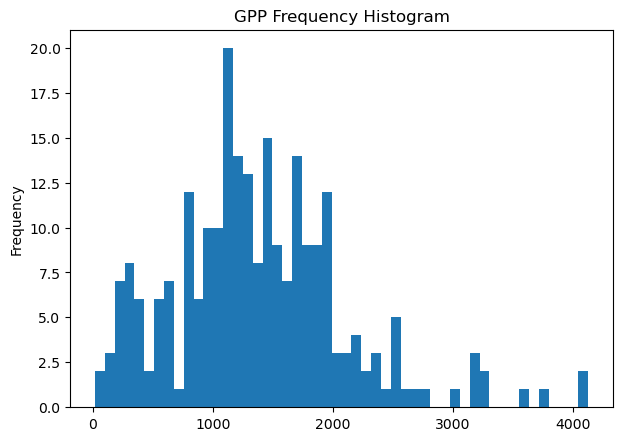

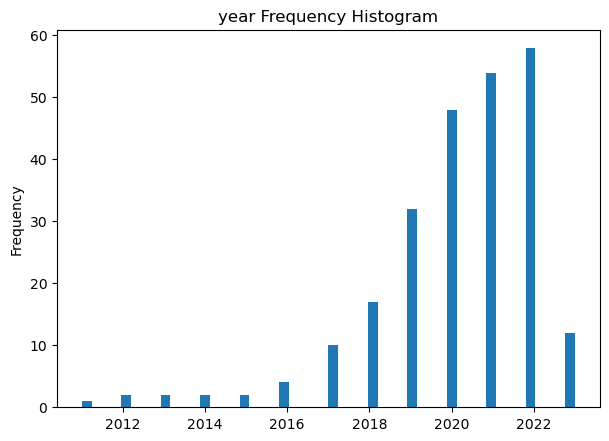

In [44]:
import matplotlib.pyplot as plt
def visualize_histogram(df, feature, save_dir=None):
    value_list = df[feature].tolist()
    plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
    # Plot Histogram on x
    plt.hist(value_list, bins=50)
    plt.gca().set(title=f'{feature} Frequency Histogram', ylabel='Frequency')
    plt.show()
    if save_dir:
        plt.savefig(save_dir)
visualize_histogram(gpp_df, 'GPP')
visualize_histogram(gpp_df, 'year')

#### Export FLUXNET data

In [60]:
EU_FILE_PREFIX = 'euronet'
NA_FILE_PREFIX = 'amerinet'


def sample_features_fluxnet(site_loc_df, gpp_df, file_prefix, scale: int):
    combine_image_only_feature_list, time_desc_list = get_combined_data(downstream_train_start_year, downstream_train_end_year, False)
    combine_image_modis_list, _ = get_combined_data(downstream_train_start_year, downstream_train_end_year)
    # combine_image_only_feature_list, time_desc_list = get_combined_data(2022, 2022, False)
    # combine_image_modis_list, _ = get_combined_data(2022, 2022)
    
    collection = ee.FeatureCollection([])
    for i,(image_flux, image_modis, time) in enumerate(zip(combine_image_only_feature_list, combine_image_modis_list, time_desc_list)):
        list_features_flux = []
        list_features_modis = []
        rows_from_this_year = gpp_df[gpp_df['year'] == time]
        for index, row in rows_from_this_year.iterrows():  
            site_loc = site_loc_df.loc[site_loc_df['site']==row['site']]
            if site_loc.shape[0] == 0:
                print(f"{row['site']} can't be found in df")
                continue
            point = ee.Geometry.Point([site_loc.iloc[0]['longitude'], site_loc.iloc[0]['latitude']])
            feature_collection = image_flux.sample(
                region=point,
                scale=scale,
                numPixels=1,
                geometries=True,
            )
            if feature_collection.size().getInfo() == 0:
                print(f"{row['site']} can't be sampled")
                continue
            feature = ee.Feature(feature_collection.toList(2).get(0))
            centroid = feature.geometry().centroid()
            feature = ee.Feature(centroid, {'Gpp': row['GPP'], 'cx': centroid.coordinates().get(0),'cy': centroid.coordinates().get(1)}).copyProperties(feature)                         
            list_features_flux.append(feature)
            
            feature_collection = image_modis.sample(
                region=point,
                scale=scale,
                numPixels=1,
            )
            feature = ee.Feature(feature_collection.toList(2).get(0))
            feature = ee.Feature(centroid, {'cx': centroid.coordinates().get(0),'cy': centroid.coordinates().get(1)}).copyProperties(feature)                         
            list_features_modis.append(feature)
            
                                     
        print(f'{time}:{len(list_features_flux)}')    
        if len(list_features_flux) ==0 or len(list_features_modis) ==0:
            continue
        collection = ee.FeatureCollection(list_features_flux)                               
        task = ee.batch.Export.table.toCloudStorage(
                collection = collection,
                description = f'{file_prefix}_{time}',
                bucket = BUCKET_NAME,
                fileNamePrefix = f'annual/{FLUX_FOLDER}{file_prefix}_{time}',
                fileFormat = 'TFRecord'
            )
        task.start()
        
        collection = ee.FeatureCollection(list_features_modis)                               
        task = ee.batch.Export.table.toCloudStorage(
                collection = collection,
                description = f'{file_prefix}_{time}',
                bucket = BUCKET_NAME,
                fileNamePrefix = f'annual/{COMPARE_UPSTREAM_SUB_FOLDER}/{file_prefix}_{time}',
                fileFormat = 'TFRecord'
            )
        task.start()

In [ ]:
sample_features_fluxnet(site_loc_df_eu, gpp_df_eu, EU_FILE_PREFIX, SAMPLE_SCALE)

In [67]:
sample_features_fluxnet(site_loc_df_na, gpp_df_na, NA_FILE_PREFIX, SAMPLE_SCALE)

no LC_Type1 in 2000-01-01-2000-12-31
no LC_Type1 in 2000-01-01-2000-12-31
no Gpp in 2001-01-01-2001-12-31
no Gpp in 2002-01-01-2002-12-31
2001:13
2002:17
2003:24
MX-Tes can't be found in df
2004:30
MX-Tes can't be found in df
2005:36
MX-Tes can't be found in df
2006:27
MX-Tes can't be found in df
2007:34
MX-Tes can't be found in df
2008:35
2009:41
2010:41
2011:46
2012:47
BR-Npw can't be found in df
2013:46
BR-Npw can't be found in df
2014:49
BR-Npw can't be found in df
2015:50
AR-TF1 can't be found in df
BR-Npw can't be found in df
2016:55
AR-TF1 can't be found in df
BR-Npw can't be found in df
2017:79
AR-TF1 can't be found in df
PE-QFR can't be found in df
US-Snf can't be sampled
2018:84
PE-QFR can't be found in df
US-HB1 can't be sampled
US-Snf can't be sampled
2019:86
US-Snf can't be sampled
2020:80
2021:52
2022:0


# Preprocess data

## Try normalizing input

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow_datasets as tfds

ALL_COLUMNS = FEATURES + [TARGET_FEATURE] + ['cx', 'cy']
columns = [tf.io.FixedLenFeature(shape=[], dtype=tf.float32) for k in ALL_COLUMNS]
FEATURES_DICT = dict(zip(ALL_COLUMNS, columns))


In [6]:
def parse_tfrecord(example_proto):
    """The parsing function.
    Read a serialized example into the structure defined by FEATURES_DICT.
    Args:
    example_proto: a serialized Example.
    Returns:
    A dictionary of tensors, keyed by feature name.
    """
    parsed_features = tf.io.parse_single_example(example_proto, FEATURES_DICT)
    # print(f'Parsed features: {parsed_features}')
    return parsed_features

def get_dataframe(pattern):
    """Function to read, parse and format to tuple a set of input tfrecord files.
    Get all the files matching the pattern, parse and convert to tuple.
    Args:
    pattern: A file pattern to match in a Cloud Storage bucket.
    Returns:
    A tf.data.Dataset
    """
    glob = tf.io.gfile.glob(pattern)
    # print(glob)
    dataset = tf.data.TFRecordDataset(glob, compression_type='GZIP')
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=5)
    # dataset = dataset.map(to_tuple, num_parallel_calls=5)
    df = tfds.as_dataframe(dataset)
    return df

In [7]:
import geemap
def visualize_sample_geo_loc(df):
    m = geemap.Map()
    m.add_points_from_xy(df, x='cx', y='cy')
    return m

In [8]:
def visualize_feature_distribution(df_list, df_name_list, single_feature = None, exaggerate_indics=[2,3], save_dir=None):
    for feature in ALL_COLUMNS:
        if single_feature and feature != single_feature or feature == 'cx' or feature == 'cy':
            continue
        plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
        for i, (df,df_name) in enumerate(zip(df_list, df_name_list)):
            if feature not in df.columns:
                print(f'{feature} is not in {df_name}')
                continue
            value_list = df[feature].tolist()
            
            if i in exaggerate_indics:
                # To make the bar more obvious for small dataset
                for m in range(5):
                    value_list.extend(value_list)
                    
            plt.hist(value_list, label=f'{df_name}', alpha=.7, edgecolor='yellow', bins=50)
        plt.title(f'{feature} Frequency Histogram')
        plt.legend()                
        plt.show()    
        if save_dir:
            plt.savefig(f'{save_dir}{feature}.png')

## Read upstream & downstream data

In [12]:
UPSTREAM_DATA_PATH = f'{BUCKET_FOLDER}/{UPSTREAM_SUB_FOLDER}/'
DOWNSTREAM_DATA_PATH = f'{BUCKET_FOLDER}/{DOWNSTREAM_SUB_FOLDER}/'
COMPARE_DATA_PATH = f'{BUCKET_FOLDER}/{COMPARE_UPSTREAM_SUB_FOLDER}/'

In [24]:
UPSTREAM_EXTRA_DATA_PATH = f'{BUCKET_FOLDER}/{UPSTREAM_SUB_FOLDER}_extra/'
df_upstream_train = concat([
    get_dataframe(f'{UPSTREAM_DATA_PATH}*_201*.tfrecord.gz'), 
    get_dataframe(f'{UPSTREAM_DATA_PATH}*_2020*.tfrecord.gz'),
    get_dataframe(f'{UPSTREAM_EXTRA_DATA_PATH}*_201*.tfrecord.gz'),
    get_dataframe(f'{UPSTREAM_EXTRA_DATA_PATH}*_2020*.tfrecord.gz'),
])

df_upstream_val = concat([
    get_dataframe(f'{UPSTREAM_DATA_PATH}*_2021*.tfrecord.gz'),
    get_dataframe(f'{UPSTREAM_EXTRA_DATA_PATH}*_2021*.tfrecord.gz')
])
# df_train = tfds.as_dataframe(dataset_upstream_train)
print(len(df_upstream_train))
print(len(df_upstream_val))

158603
26435


Remove invalid Gpp

In [10]:
def drop_invalid_rows(df):
    df = df.drop(df[df['Gpp'] > 60000].index)    
    return df

In [25]:
df_upstream_train = drop_invalid_rows(df_upstream_train)
df_upstream_val = drop_invalid_rows(df_upstream_val)
print(f'upstream training dataset: {len(df_upstream_train)}')
print(f'upstream validation dataset: {len(df_upstream_val)}')

upstream training dataset: 141623
upstream validation dataset: 23624


In [13]:
df_downstream_train = concat([
    get_dataframe(f'{DOWNSTREAM_DATA_PATH}*_20[0-1]*.tfrecord.gz'), 
    get_dataframe(f'{DOWNSTREAM_DATA_PATH}*_2020*.tfrecord.gz')
])
df_downstream_test = get_dataframe(f'{DOWNSTREAM_DATA_PATH}*_202[1-2].tfrecord.gz')
print(len(df_downstream_train))
print(len(df_downstream_test))

996
160


In [16]:
df_cp_modis_train = concat([
    get_dataframe(f'{COMPARE_DATA_PATH}*_20[0-1]*.tfrecord.gz'), 
    get_dataframe(f'{COMPARE_DATA_PATH}*_2020*.tfrecord.gz')
])
df_cp_modis_test = get_dataframe(f'{COMPARE_DATA_PATH}*_202[1-2].tfrecord.gz')
# df_cp_modis_train = drop_invalid_rows(df_cp_modis_train)
# df_cp_modis_test = drop_invalid_rows(df_cp_modis_test)
print(len(df_cp_modis_train))
print(len(df_cp_modis_test))

996
160


In [35]:
def get_invalid_lat(df): 
    return df[df['cy'] < 10].index
    
print(get_invalid_lat(df_cp_modis_train))
print(get_invalid_lat(df_cp_modis_test))
print(df_cp_modis_train.iloc[get_invalid_lat(df_cp_modis_train)])

Int64Index([823, 836, 860, 955, 984], dtype='int64')
Int64Index([57, 89, 109, 144], dtype='int64')
        EVI      Gpp  LC_Type1  LST_Day_1km    NDVI      aet         cx  \
823  3866.0  32850.0       2.0     15038.00  7481.0  12050.0 -52.926491   
836  3863.0  36017.0       2.0     15018.00  6028.0  12051.0 -52.926491   
860  3863.0  33863.0       2.0     15025.00  6777.0  12946.0 -52.926491   
955  4834.0  25076.0       2.0     15035.25  8390.0  11457.0  24.503796   
984  4042.0  34775.0       2.0     15038.00  6246.0  13114.0 -52.926491   

           cy      pr  
823  5.279848  2914.0  
836  5.279848  2909.0  
860  5.279848  2617.0  
955  0.815221  1534.0  
984  5.279848  3699.0  


Remove invalid Gpp

In [18]:
# Scale of MOD17 is 0.0001 for kg/m^2/year
# Scale of FLUX is g/m^2/year
# So scale FLUX by 10 to match the two
FLUXNET_GPP_SCALE = 10

df_downstream_train[TARGET_FEATURE] = df_downstream_train[TARGET_FEATURE]*FLUXNET_GPP_SCALE
df_downstream_test[TARGET_FEATURE] = df_downstream_test[TARGET_FEATURE]*FLUXNET_GPP_SCALE
print(df_downstream_train.head())

      EVI           Gpp  LC_Type1  LST_Day_1km    NDVI     aet          cx  \
0  4089.0  19629.900391       1.0      14388.5  8747.0  4806.0 -125.335197   
1  3057.0   5300.430176       1.0      14603.0  6984.0  5071.0 -125.290276   
2  3182.0  12964.699219       5.0      14589.5  6372.0  5690.0  -79.934341   
3  2529.0  16307.099609       5.0      14343.0  5465.0  4617.0  -82.157669   
4  1922.0   8113.720215       8.0      14218.5  3693.0  4669.0  -98.484550   

          cy      pr  
0  49.867725  1635.0  
1  49.872219  1532.0  
2  44.316139   876.0  
3  48.214828   732.0  
4  55.877457   545.0  


In [27]:
df_downstream_train = df_downstream_train.drop(df_downstream_train[df_downstream_train['cy'] < 10].index)
df_downstream_test = df_downstream_test.drop(df_downstream_test[df_downstream_test['cy'] < 10].index)

In [28]:
print(f'upstream training data 2015-2020:   {len(df_upstream_train)}')
print(f'upstream validation data 2021:      {len(df_upstream_val)}')
print(f'downstream training data 2001-2020: {len(df_downstream_train)}')
print(f'downstream test data 2021-2022:     {len(df_downstream_test)}')
print(f'modis downstream data 2001-2020:    {len(df_cp_modis_train)}')
print(f'modis downstream data 2021-2022:    {len(df_cp_modis_test)}')

upstream training data 2015-2020:   141623
upstream validation data 2021:      23624
downstream training data 2001-2020: 991
downstream test data 2021-2022:     156
modis downstream data 2001-2020:    991
modis downstream data 2021-2022:    156


### Inspect data distribution

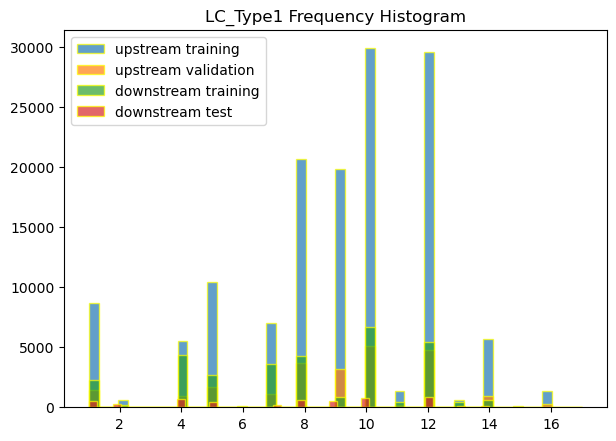

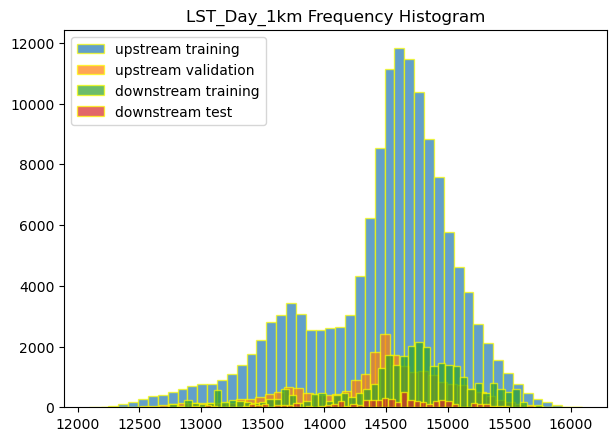

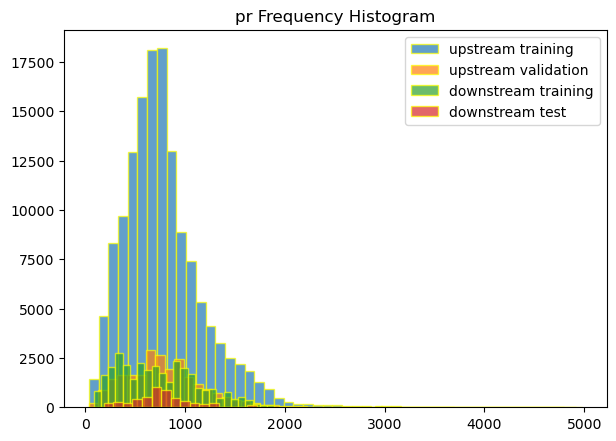

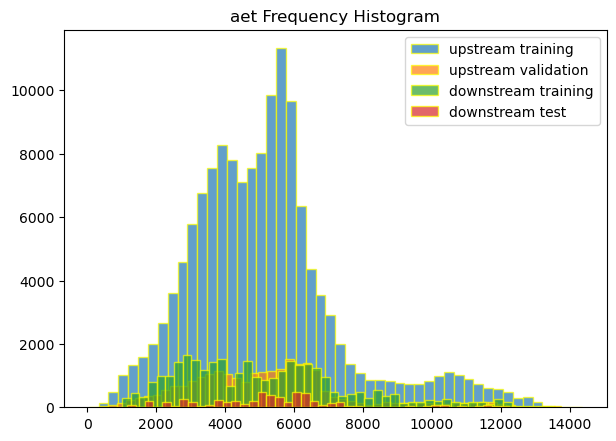

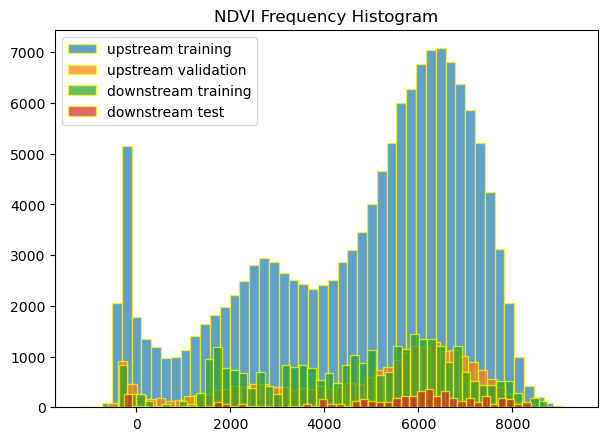

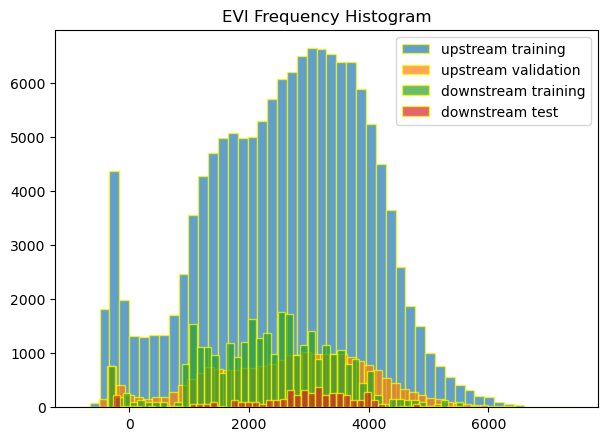

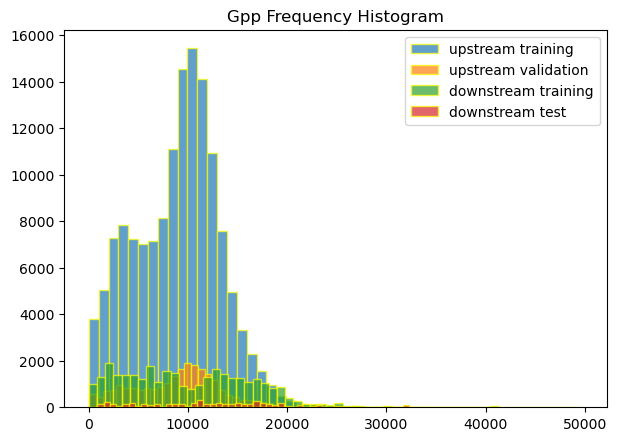

In [19]:
visualize_feature_distribution(
    [df_upstream_train, df_upstream_val, df_downstream_train, df_downstream_test], 
    ['upstream training','upstream validation','downstream training', 'downstream test'])

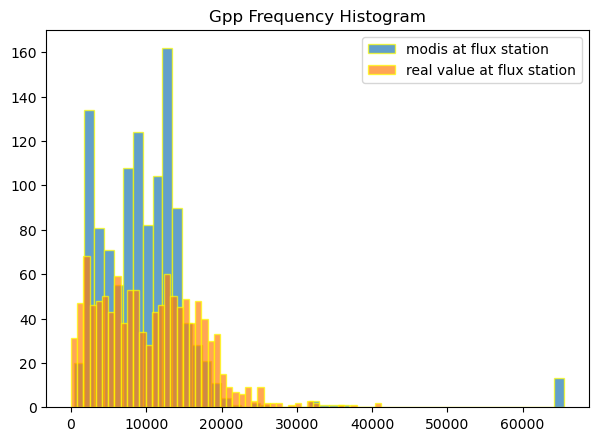

In [23]:
visualize_feature_distribution(
    [concat([df_cp_modis_train,df_cp_modis_test]), concat([df_downstream_train, df_downstream_test])], 
    ['modis at flux station','real value at flux station'],
    'Gpp',
    [])

### Visualize the samples on geomap

In [24]:
import plotly.graph_objects as go

def plot_samples_on_map(df_to_plot, size=5, colorscale='Viridis'):
    fig = go.Figure(go.Scattergeo(
        lat=df_to_plot['cy'],
        lon=df_to_plot['cx'],
        marker=dict(size=size, color=df_to_plot['LC_Type1'], colorscale=colorscale)
    ), layout=dict(height=1200, width=1500, margin={"r":0,"t":0,"l":0,"b":0}))
    fig.show()

In [ ]:
df_cp_modis_train = df_cp_modis_train.drop(df_cp_modis_train[df_cp_modis_train['cy'] < 10].index)
df_cp_modis_test = df_cp_modis_test.drop(df_cp_modis_test[df_cp_modis_test['cy'] < 10].index)
print(len(df_cp_modis_train))
print(len(df_cp_modis_test))
plot_samples_on_map(concat([df_cp_modis_train, df_cp_modis_test]), size=7)

In [ ]:
plot_samples_on_map(concat([df_upstream_train, df_upstream_val]), size=1)

In [19]:
visualize_sample_geo_loc(concat([df_cp_modis_train, df_cp_modis_test]))

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [43]:
visualize_sample_geo_loc(concat([df_downstream_train, df_downstream_test]))

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [24]:
all_dataset_list = [df_upstream_train, df_upstream_val, df_downstream_train, df_downstream_test, df_cp_modis_train, df_cp_modis_test]

def seperate_xy():
    all_x = []
    all_y = []
    for dt in all_dataset_list:
        x = dt[FEATURES]        
        y = dt[[TARGET_FEATURE]]
        all_x.append(x)        
        all_y.append(y)
    return all_x, all_y

In [25]:
from sklearn.preprocessing import (MinMaxScaler, RobustScaler)

def get_normalize_features(numeric_features, fit_target, transform_list):
    # fit scaler on training data
    # norm = MinMaxScaler().fit(fit_target[numeric_features])
    norm = RobustScaler().fit(fit_target[numeric_features])
    norm_list=[]
    for transform_target in transform_list:
        transformed = transform_target.copy()
        transformed[numeric_features] = norm.transform(transform_target[numeric_features])
        norm_list.append(transformed)
    
    return norm_list

In [26]:
separate_x_dataset_list, separate_y_dataset_list = seperate_xy()
normalized_dataset_list = get_normalize_features(NUMERIC_FEATURES, separate_x_dataset_list[0], separate_x_dataset_list)

In [27]:
PROCESSED_OUTPUT_FOLDER = '../processed-datasets/'
names = ['upstream_train', 'upstream_val', 'downstream_train', 'downstream_test', 'compare_modis_train','compare_modis_test']
def export_csv_for_future_use():
    for name, x, y in zip(names, normalized_dataset_list, separate_y_dataset_list):
        combined_df = pd.concat([x, y], axis=1)
        print(f'{name}: {len(combined_df)}')
        combined_df.to_csv(f'{PROCESSED_OUTPUT_FOLDER}{name}.csv', index=False)
    
export_csv_for_future_use()

upstream_train: 141623
upstream_val: 23624
downstream_train: 996
downstream_test: 160
compare_modis_train: 996
compare_modis_test: 160
